In [2]:
import sys
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
import pandas as pd
import numpy as np

In [137]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


`%matplotlib` prevents importing * from pylab and numpy


In [4]:
d, info = matlab.loaddata('../../mat/strategy_270225.mat')

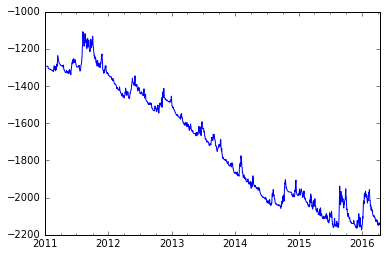

In [5]:
d.exo.plot();

In [6]:
info

{'legs': 4,
 'name': 'BearishCollarBrokenWing',
 'pcf': array([1, 2, 0, 1], dtype=uint8),
 'pcfqty': array([-1, -1,  1,  1], dtype=int16),
 'tickincrement': 0.25,
 'tickvalue': 12.5,
 'underlying': 'EP'}

# Naive swarming


In [20]:
def naive_swarm():
    for slowp in np.arange(40, 100, 5):
            for fastp in np.arange(5, 20, 2):
                slow_ma = d.exo.rolling(slowp).mean()
                fast_ma = d.exo.rolling(fastp).mean()

                short_entry = CrossDown(fast_ma, slow_ma)
                short_exit = CrossUp(fast_ma, slow_ma)

                direction = -1
                pl1, inposition1 = backtester.backtest(d, short_entry, short_exit, direction )
                equity1, stats1 = backtester.stats(pl1, inposition1)
                equity1.plot()


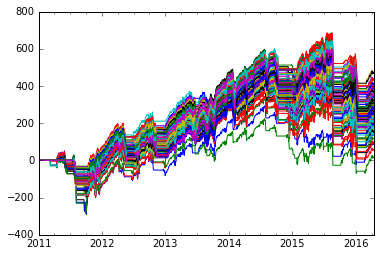

In [21]:
%prun naive_swarm()

# Cython optimized backtesting

In [6]:
%load_ext Cython

In [7]:
%%cython 
# --annotate

import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt
import pandas as pd

DTYPE = np.int
ctypedef np.double_t DTYPE_t_double
ctypedef np.int8_t DTYPE_t_int8

@cython.boundscheck(False) # turn of bounds-checking for entire function
def stats(profitloss, inposition):
    """
    Calculate equity and summary statistics, based on output of `backtest` method
    :param pl: Profit-loss array (returned by backtest())
    :param inposition: In-position array (returned by backtest())
    :return: tuple (equity, stats)
        - equity - is cumulative profits arrat
        - stats - is a dict()
    """    
    cdef int barcount = len(profitloss)
    cdef np.ndarray[np.double_t, ndim=1] equity = np.zeros(barcount, dtype=np.double)
    cdef np.ndarray[DTYPE_t_double, ndim=1] pl = profitloss.values
    cdef np.ndarray[DTYPE_t_int8, ndim=1] inpos = inposition.values
    cdef double profit = 0.0
    
    cdef double netprofit = 0.0
    cdef double tradeprofit = 0.0
    cdef double count = 0.0
    cdef double winscount = 0.0
    cdef double highesteqty = 0.0
    cdef double maxdd = 0.0
    cdef double p = 0.0
    cdef double cumulativep = 0.0
    # 
    
    # Calculate trade-by-trade payoffs        
    for i in range(barcount):
        if i == 0:
            continue
        # Calculate cumulative profit inside particular trade
        p = pl[i]
        if np.isnan(p):
            continue
        
        cumulativep += p
        if inpos[i] == 1:
            tradeprofit += p
        # Store result
        if inpos[i] == 0 and inpos[i-1] == 1:            
            count += 1.0
            if tradeprofit > 0:
                winscount += 1.0         
            netprofit += tradeprofit
            tradeprofit = 0.0
            
        highesteqty = max(highesteqty, cumulativep)   
        maxdd = min(maxdd, cumulativep - highesteqty)                
        equity[i] = cumulativep 
    

    # Calculate summary statistics
    statistics = {
        'netprofit': netprofit,
        'avg': netprofit / count,
        'count': count,
        'winrate': winscount / count,
        'maxdd': maxdd,
    }
    return pd.Series(equity, index=profitloss.index), statistics

In [9]:
def optimized_swarm():
    for slowp in np.arange(40, 100, 5):
            for fastp in np.arange(5, 20, 2):
                slow_ma = d.exo.rolling(slowp).mean()
                fast_ma = d.exo.rolling(fastp).mean()

                short_entry = CrossDown(fast_ma, slow_ma)
                short_exit = CrossUp(fast_ma, slow_ma)

                direction = -1
                # Calling Cython optimized methods
                pl2, inposition2 = backtest(d, short_entry, short_exit, direction )
                equity2, stats2 = stats(pl2, inposition2)


In [18]:
%prun optimized_swarm()

In [10]:
slow_ma = d.exo.rolling(50).mean()
fast_ma = d.exo.rolling(20).mean()
short_entry = CrossDown(fast_ma, slow_ma)
short_exit = CrossUp(fast_ma, slow_ma)
direction = -1

In [32]:
%%cython 
#--annotate

import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt
import pandas as pd

DTYPE = np.int

ctypedef np.double_t DTYPE_t_double

@cython.boundscheck(False) # turn of bounds-checking for entire function
def backtest(np.ndarray[np.double_t, ndim=1] price, 
             np.ndarray[np.uint8_t,cast=True, ndim=1] entry_rule, 
             np.ndarray[np.uint8_t,cast=True, ndim=1] exit_rule, 
             int direction,
             date):
    """
    Backtester routine calculate equity based on data['exo'] and entry/exit rules
    :param data: raw data for backtesting
    :param entry_rule: 1/0 array of entry points
    :param exit_rule: 1/0 array of exit points
    :param direction: Direction of trades, 1 - for long, -1 - for shorts
    :return: tuple(pl, inposition)
        pl - profit-loss inside a particular trade
        inposition - 1/0 array indicating whether the EXO is in or out of the market at the end of the day
    """    
    cdef int barcount = len(price)
    cdef np.ndarray[np.double_t, ndim=1] pl = np.zeros(barcount, dtype=np.double)
    cdef np.ndarray[np.int8_t,   ndim=1] inposition = np.zeros(barcount, dtype=np.int8)
    
    inpos = False

    for i in range(barcount):
        if not inpos:
            # We have a signal, let's open position
            if entry_rule[i] == 1:
                pl[i] = 0
                inpos = True
                inposition[i] = 1
            else:
                inposition[i] = 0

        else:
            # Calculate pl
            pl[i] = (price[i] - price[i-1])*direction
            inposition[i] = 1

            if exit_rule[i] == 1:
                inpos = False
                
    return pd.Series(pl, index=date),  pd.Series(inposition, index=date)

### Timing compare between naive python and cython optimized code

In [11]:
# Naive python timings
%timeit backtester.backtest(d, short_entry, short_exit, direction )

100 loops, best of 3: 10.7 ms per loop


In [31]:
# Cython optimized code
%timeit backtest(d.exo.values, short_entry.values, short_exit.values, direction, d.exo.index)


100 loops, best of 3: 3.83 ms per loop


# Recursion test for swarming algorithm

In [10]:
class OptParam(object):
    def __init__(self, name, default_value, min_value, max_value, step):
        self.name = name
        self.default = default_value
        self.min = min_value
        self.max = max_value
        self.step = step       
    
        

### I've tried a lot of approaches to optimal parameters scrambling, including nested loops, recursive functions, but the best solution is in use of built-in itertools module, it's fast and clean!


In [35]:
opts = [
OptParam('test1', 1, 1, 5, 1),
OptParam('test2', 1, 10, 20, 2),
OptParam('test3', .1, .10, 1, .2)
]

In [36]:
import itertools

In [37]:
def slice_opts(opts):
    result = []
    for o in opts:
        result.append(np.arange(o.min, o.max, o.step))
        
    return result

In [38]:
#
# Parameters scrambling for 3 sample optimize arrays
#
list(itertools.product(*[[2,3,4], [.2,0.3,.4], [.2,0.3,.4]]))

[(2, 0.2, 0.2),
 (2, 0.2, 0.3),
 (2, 0.2, 0.4),
 (2, 0.3, 0.2),
 (2, 0.3, 0.3),
 (2, 0.3, 0.4),
 (2, 0.4, 0.2),
 (2, 0.4, 0.3),
 (2, 0.4, 0.4),
 (3, 0.2, 0.2),
 (3, 0.2, 0.3),
 (3, 0.2, 0.4),
 (3, 0.3, 0.2),
 (3, 0.3, 0.3),
 (3, 0.3, 0.4),
 (3, 0.4, 0.2),
 (3, 0.4, 0.3),
 (3, 0.4, 0.4),
 (4, 0.2, 0.2),
 (4, 0.2, 0.3),
 (4, 0.2, 0.4),
 (4, 0.3, 0.2),
 (4, 0.3, 0.3),
 (4, 0.3, 0.4),
 (4, 0.4, 0.2),
 (4, 0.4, 0.3),
 (4, 0.4, 0.4)]

In [39]:
slice_opts(opts)

[array([1, 2, 3, 4]),
 array([10, 12, 14, 16, 18]),
 array([ 0.1,  0.3,  0.5,  0.7,  0.9])]

In [40]:
#
# Slicing a list of  OptParam (proof of concept)
#
list(itertools.product(*slice_opts(opts)))

[(1, 10, 0.10000000000000001),
 (1, 10, 0.30000000000000004),
 (1, 10, 0.50000000000000011),
 (1, 10, 0.70000000000000007),
 (1, 10, 0.90000000000000013),
 (1, 12, 0.10000000000000001),
 (1, 12, 0.30000000000000004),
 (1, 12, 0.50000000000000011),
 (1, 12, 0.70000000000000007),
 (1, 12, 0.90000000000000013),
 (1, 14, 0.10000000000000001),
 (1, 14, 0.30000000000000004),
 (1, 14, 0.50000000000000011),
 (1, 14, 0.70000000000000007),
 (1, 14, 0.90000000000000013),
 (1, 16, 0.10000000000000001),
 (1, 16, 0.30000000000000004),
 (1, 16, 0.50000000000000011),
 (1, 16, 0.70000000000000007),
 (1, 16, 0.90000000000000013),
 (1, 18, 0.10000000000000001),
 (1, 18, 0.30000000000000004),
 (1, 18, 0.50000000000000011),
 (1, 18, 0.70000000000000007),
 (1, 18, 0.90000000000000013),
 (2, 10, 0.10000000000000001),
 (2, 10, 0.30000000000000004),
 (2, 10, 0.50000000000000011),
 (2, 10, 0.70000000000000007),
 (2, 10, 0.90000000000000013),
 (2, 12, 0.10000000000000001),
 (2, 12, 0.30000000000000004),
 (2, 12,

# Creating prototype of strategy class

In [61]:
class StrategyBase(object):
    def __init__(self):
        self.name = 'BaseStrategy'        
        self.opts = [
            OptParam('test1', 1, 1, 5, 1),
            OptParam('test2', 1, 10, 20, 2),            
            ]
        
    def slice_opts(self):
        if self.opts is None:
            return [None]
        
        result = []
        for o in self.opts:
            result.append(np.arange(o.min, o.max, o.step))
        return itertools.product(*result)
    
    
    def run_swarm(self):
        '''
        Brute force all steps of self.opts and calculate base stats
        '''
        
        # loop through all steps of every OptParam
        # Calculate algo
        # Store the results
        for opts in self.slice_opts():
           equity, stats = self.calculate(opts)                        
            
    
    def calculate(self,params):
        '''
        The main algorithm for trading logics calculation
        params: tuple-like object with optimizations parameters
        '''
        print(params)
        return None, None

In [62]:
StrategyBase().run_swarm()

(1, 10)
(1, 12)
(1, 14)
(1, 16)
(1, 18)
(2, 10)
(2, 12)
(2, 14)
(2, 16)
(2, 18)
(3, 10)
(3, 12)
(3, 14)
(3, 16)
(3, 18)
(4, 10)
(4, 12)
(4, 14)
(4, 16)
(4, 18)


In [63]:
opts = [OptParam('SlowMAPeriod', 50, 50, 100, 2),
OptParam('FastMAPeriod', 10, 10, 50, 2),
OptParam('MedianPeriod', 5, 5, 20, 5)]
slice_opts(opts)

[array([50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82,
        84, 86, 88, 90, 92, 94, 96, 98]),
 array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42,
        44, 46, 48]),
 array([ 5, 10, 15])]

# Swarm picking algorithm

In [54]:
data = {}
for slowp in np.arange(10, 20, 1):
        for fastp in np.arange(2, 10, 2):
            slow_ma = d.exo.rolling(slowp).mean()
            fast_ma = d.exo.rolling(fastp).mean()

            short_entry = CrossDown(fast_ma, slow_ma)
            short_exit = CrossUp(fast_ma, slow_ma)

            direction = -1
            pl1, inposition1 = backtester.backtest(d, short_entry, short_exit, direction )
            #trades = backtester.trades(pl1, inposition1)
            equity, stats = backtester.stats(pl1, inposition1)
            data[ str((slowp, fastp)) ] = equity
            

In [55]:
trades.describe()

count     33.000000
mean      -4.610606
std       43.221864
min     -118.000000
25%      -28.850000
50%       -2.750000
75%       32.150000
max       77.150000
dtype: float64

In [56]:
df = pd.DataFrame.from_dict(data)

In [57]:
df.apply(lambda x: x.rolling(10).mean())

,"(10, 2)","(10, 4)","(10, 6)","(10, 8)","(11, 2)","(11, 4)","(11, 6)","(11, 8)","(12, 2)","(12, 4)",...,"(17, 6)","(17, 8)","(18, 2)","(18, 4)","(18, 6)","(18, 8)","(19, 2)","(19, 4)","(19, 6)","(19, 8)"
2011-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-14,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [58]:
df

,"(10, 2)","(10, 4)","(10, 6)","(10, 8)","(11, 2)","(11, 4)","(11, 6)","(11, 8)","(12, 2)","(12, 4)",...,"(17, 6)","(17, 8)","(18, 2)","(18, 4)","(18, 6)","(18, 8)","(19, 2)","(19, 4)","(19, 6)","(19, 8)"
2011-01-03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2011-01-04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2011-01-05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2011-01-06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2011-01-07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2011-01-10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2011-01-11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2011-01-12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2011-01-13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2011-01-14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [88]:
class SwarmRank(object):
    def __init__(self, reranktime):
        self.reranktime = reranktime
        
    def rank_highestret(self, eqty):
        """
        Ranking function
        Calculate last 14 days equity returns, excluding out-of-market time
        """
        
        if len(self.reranktime) != len(eqty):
            raise ValueError('Length of self.reranktime != equity length')
            
        result = np.full_like(eqty, np.nan)
        
        for i in range(len(self.reranktime)):            
            # Skip 14 days
            if i < 15:
                continue
                        
            if self.reranktime[i]:
                # We at the point of reranking
                
                # Skip periods without trades
                e = np.unique(eqty[:i+1])
                
                if len(e) < 15:
                    continue
                    
                # Recalculate last 14 day returns
                result[i] = e[len(e) - 1] - e[len(e) - 14]
                
        return pd.Series(result, index=eqty.index)
                
       
    
    

In [143]:
# Number of swarm members to pick
nSystems = 5

# Rebalance the swarm every Monday
rerank_time = df.index.dayofweek == 0

# Rank systems
ranking_algo =  SwarmRank(rerank_time)

# Last 14 days returns rank
rets = df.apply(ranking_algo.rank_highestret)
rnk = rets.rank(axis=1, pct=True)


is_picked_df = pd.DataFrame(False, index=df.index, columns=df.columns)
nbest = None

for i in range(len(rerank_time)):
    if i < 100:
        continue 
    if rerank_time[i]:
        # Select N best ranked systems to trade
        nbest = rnk.iloc[i].sort_values()
        
        # Filter early trades
        if nbest.sum() == 0:
            nbest[:] = False
            continue
        
        # Flagging picked trading systems
        nbest[-nSystems:] = True
        nbest[:-nSystems] = False
        is_picked_df.iloc[i] = nbest        
        
    else:
        # Flag last picked swarm members untill new rerank_time
        if nbest is not None:
            is_picked_df.iloc[i] = nbest        
            
               

# Average equity comparison

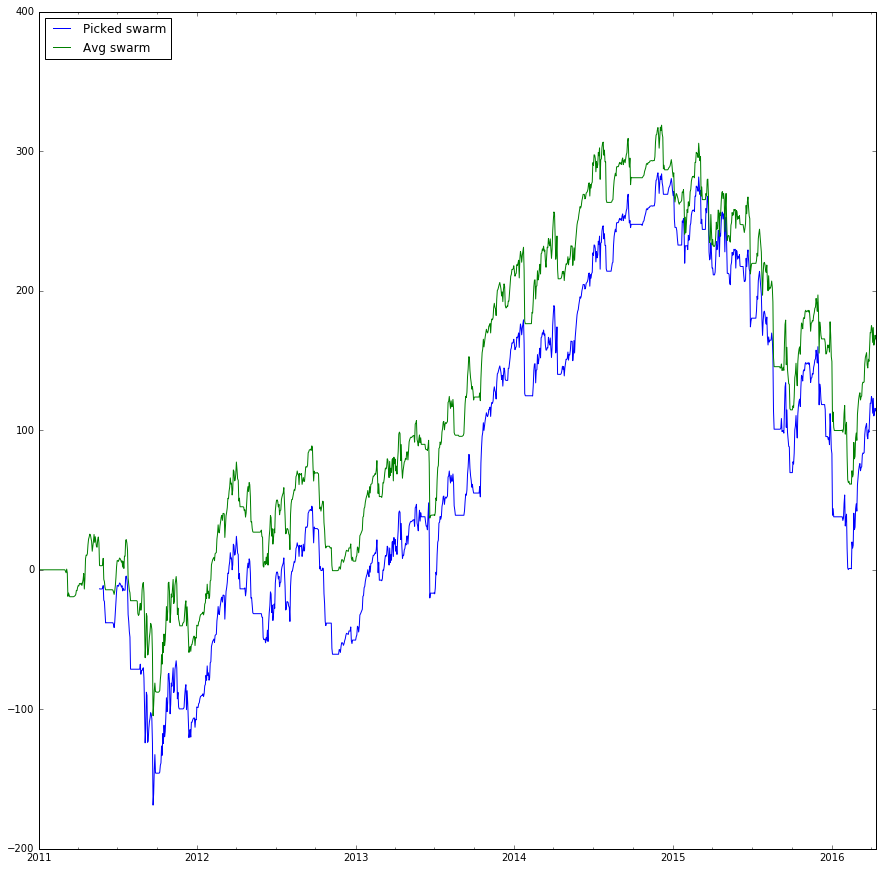

In [145]:
figsize(15,15)

#
# Compose average equity for picked swarms members and all-in-one average
#
eq_changes = df.diff()
avg_picked_equity = eq_changes[is_picked_df].mean(axis=1).cumsum()
avg_all_equity = eq_changes.mean(axis=1).cumsum()


avg_picked_equity.plot(label='Picked swarm')
avg_all_equity.plot(c='g', label='Avg swarm')
legend(loc=2)